In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import inspect
import sys
pd.set_option('display.max_colwidth', None)

In [3]:
import pandas as pd
import os


def import_data(dataset):
    '''Imports sepcified dataset fomr raw_data directory.

        Parameters:
                dataset (str): energy_data or weather_features

        Returns:
                DataFrame
    '''

    path = '/home/rahmah/code/marvinliebisch/forecasting-electricity-prices'
    full_path = path + '/raw_data/' + dataset + '.csv'
    print(f"Importing {dataset} data from {full_path}...")
    df_raw = pd.read_csv(full_path)

    return df_raw


def import_clean_energy_data(dropNA=True):
    '''Returns clean energy data.

        Parameters:
                dropNA (bool): Default is True (Dropping NA rows)

        Returns:
                DataFrame
    '''
    df_energy = import_data('energy_dataset')
    df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
    df_energy['time'] = df_energy['time'].dt.tz_convert('Europe/Madrid')
    df_energy = df_energy.set_index('time')
    df_energy = df_energy.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'generation marine', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation fossil coal-derived gas', 'generation wind offshore'])
    df_energy.columns = df_energy.columns.str.replace(' ', '_')

    if dropNA == True:
        df_energy = df_energy.dropna()

    return df_energy


def import_clean_weather_data():
    '''Returns clean weather data.

        Parameters:
                None

        Returns:
                DataFrame
    '''
    df_weather = import_data('weather_features')
    df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True)
    df_weather = df_weather.rename(columns={'dt_iso': 'time'})
    df_weather = df_weather.set_index('time')

    return df_weather


def import_merged_data(FeatureEngineering = True, TempMin = False, TempMax = False, WeatherIcon = False):
    '''Returns merged DataFrame containing the energy and weather data.

    Parameters:
            FeatureEngineering (bool): Default is True
            (Creates several time based features
            e.g. season, month, day of week, weekend, hour)

            TempMin, TempMax, WeatherIcon (bool): Default is False
            (Drops specified weather columns entirely)

    Returns:
            DataFrame
    '''

    df_energy = import_clean_energy_data(dropNA=True)
    df_weather = import_clean_weather_data()

    if FeatureEngineering == True:
        df_energy['hour'] = df_energy.index.hour
        df_energy['month'] = df_energy.index.month

        season_dict = {1: 'Winter',
                    2: 'Winter',
                    3: 'Spring',
                    4: 'Spring',
                    5: 'Spring',
                    6: 'Summer',
                    7: 'Summer',
                    8: 'Summer',
                    9: 'Fall',
                    10: 'Fall',
                    11: 'Fall',
                    12: 'Winter'}

        df_energy['season'] = df_energy.index.month.map(lambda x: season_dict[x])
        df_energy['weekend'] = (df_energy.index.dayofweek > 4).astype(int)
        df_energy['day_of_week'] = df_energy.index.dayofweek

    if TempMin == False:
        df_weather = df_weather.drop(columns=['temp_min'])
    if TempMax == False:
        df_weather = df_weather.drop(columns=['temp_max'])
    if WeatherIcon == False:
        df_weather = df_weather.drop(columns=['weather_icon'])

    df_weather['city_name'] = df_weather['city_name'].str.strip()
    city_array = df_weather['city_name'].unique()
    grouped = df_weather.groupby(df_weather.city_name)
    df_merged = df_energy

    for city in city_array:
        df_merged = df_merged.join(grouped
                                   .get_group(city)
                                   .drop(columns=['city_name'])
                                   .add_prefix(city.lower() + '_'))

    return df_merged



In [4]:
data_energy = import_clean_energy_data()
data_energy.head()

Importing energy_dataset data from /home/rahmah/code/marvinliebisch/forecasting-electricity-prices/raw_data/energy_dataset.csv...


generation_biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   

                           generation_hydro_run-of-river_and_poundage  \
time                                                                    
2015-01-01 00:00:00+01:00                                      1051.0   
2015-01-01 01:00:00+01:00                                      1009.0   
2015-01-01 02:00:00+01:00                                       973.0   
2015-01-01 03:00:00+01:00                                       949.0   
2015-01-01 04:00:00+01:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2015-01-01 00:00:00+01:00                            1899.0   
2015-01-01 01:00:00+01:00                            1658.0   
2015-01-01 02:00:00+01:00                            1371.0   
2015-01-01 03:00:00+01:00                             779.0   
2015-01-01 04:00:00+01:00                             720.0   

                           generation_nuclear  generation_other  \
time                                                              
2015-01-01 00:00:00+01:00              7096.0              43.0   
2015-01-01 01:00:00+01:00              7096.0              43.0   
2015-01-01 02:00:00+01:00              7099.0              43.0   
2015-01-01 03:00:00+01:00              7098.0              43.0   
2015-01-01 04:00:00+01:00              7097.0              43.0   

                           generation_other_renewable  generation_solar  \
time                                                                      
2015-01-01 00:00:00+01:00                        73.0              49.0   
2015-01-01 01:00:00+01:00                        71.0              50.0   
2015-01-01 02:00:00+01:00            

In [5]:
data_energy.shape

(35018, 20)

In [6]:
data_energy.describe

<bound method NDFrame.describe of                            generation_biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 32

In [7]:
data_energy.info

<bound method DataFrame.info of                            generation_biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.

In [8]:
data_energy.dtypes

generation_biomass                             float64
generation_fossil_brown_coal/lignite           float64
generation_fossil_gas                          float64
generation_fossil_hard_coal                    float64
generation_fossil_oil                          float64
generation_hydro_pumped_storage_consumption    float64
generation_hydro_run-of-river_and_poundage     float64
generation_hydro_water_reservoir               float64
generation_nuclear                             float64
generation_other                               float64
generation_other_renewable                     float64
generation_solar                               float64
generation_waste                               float64
generation_wind_onshore                        float64
forecast_solar_day_ahead                       float64
forecast_wind_onshore_day_ahead                float64
total_load_forecast                            float64
total_load_actual                              float64
price_day_

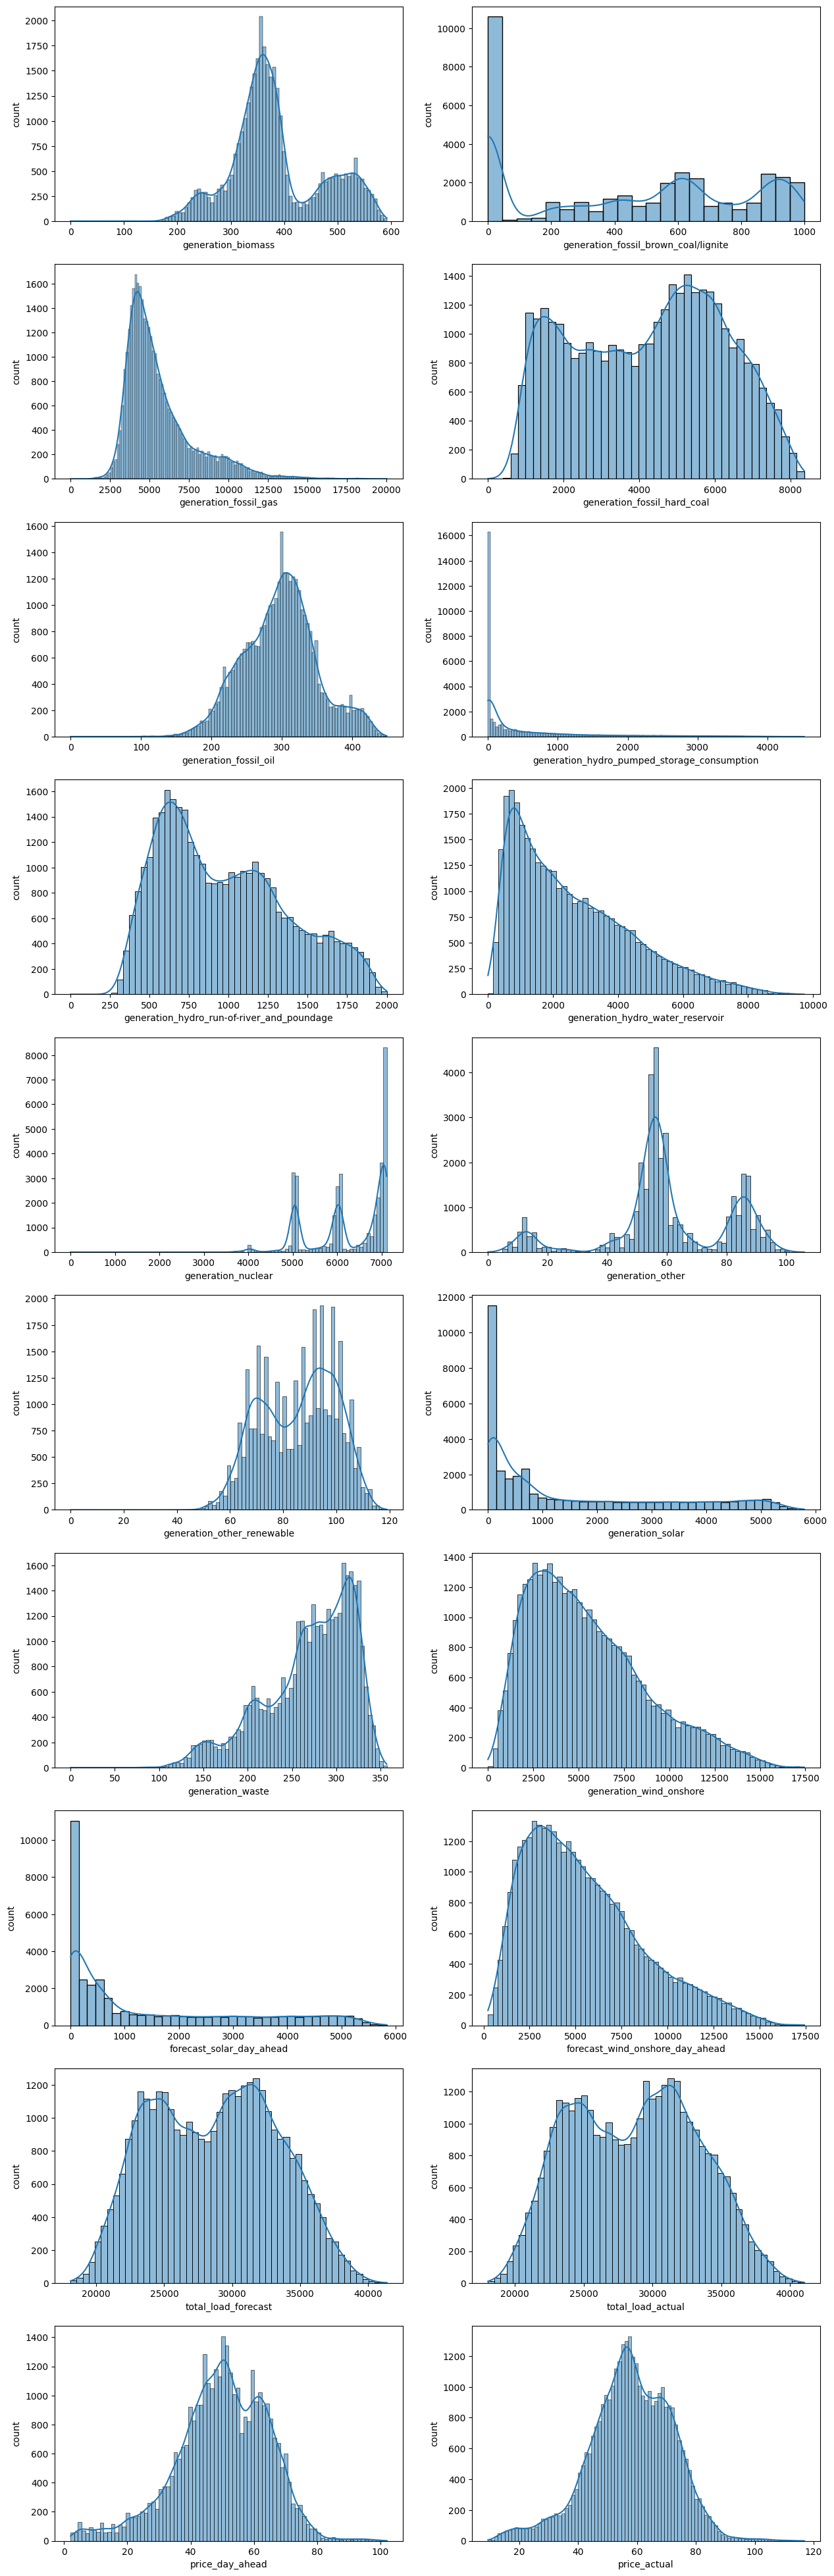

In [10]:
# histogram to see normal distribution of data energy features 
df = data_energy
plt.figure(figsize=(15,50))
columns = df.columns
for col in range(0,20):
    ax = plt.subplot(10,2,col+1)
    sns.histplot(df[columns[col]], kde=True, ax=ax)
    plt.xlabel(columns[col])
    plt.ylabel('count')

Text(0.5, 1.0, 'price day ahead')

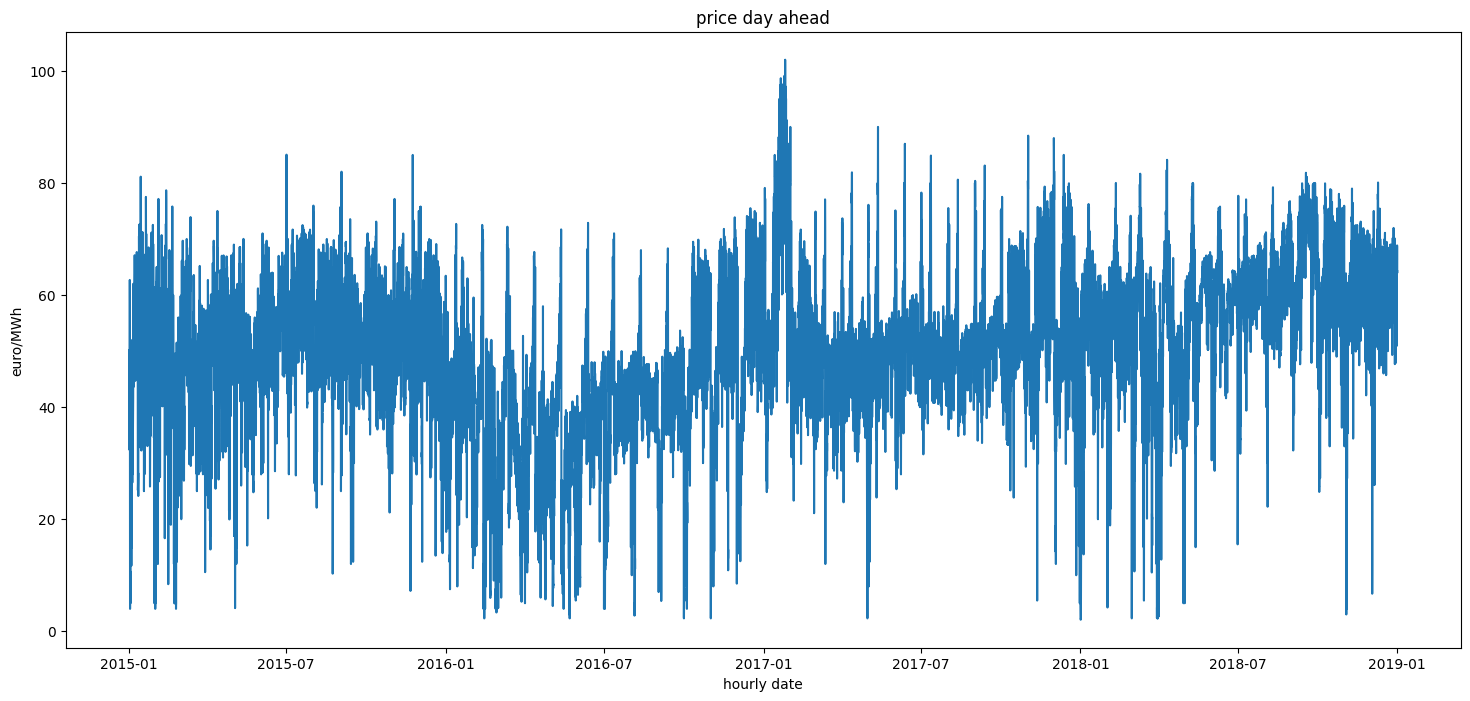

In [11]:
#timeseries for price day ahead

plt.figure(figsize=(18,8))
plt.plot(df['price_day_ahead'])
plt.xlabel('hourly date')
plt.ylabel('euro/MWh')
plt.title('price day ahead')

Text(0.5, 1.0, 'price actual')

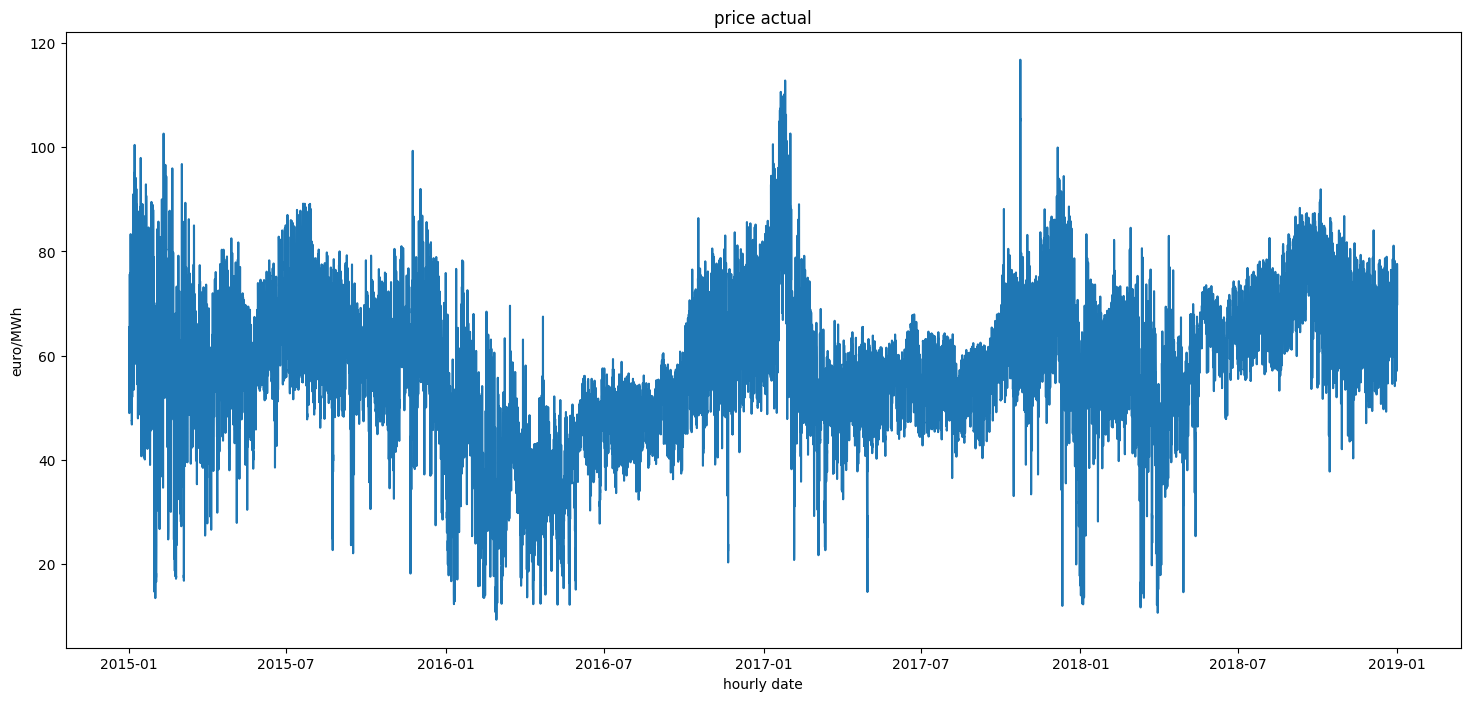

In [12]:
#timeseries for price actual

plt.figure(figsize=(18,8))
plt.plot(df['price_actual'])
plt.xlabel('hourly date')
plt.ylabel('euro/MWh')
plt.title('price actual')

/home/rahmah/.pyenv/versions/3.10.6/envs/forecasting-electricity-prices/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/rahmah/.pyenv/versions/3.10.6/envs/forecasting-electricity-prices/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/rahmah/.pyenv/versions/3.10.6/envs/forecasting-electricity-prices/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and p

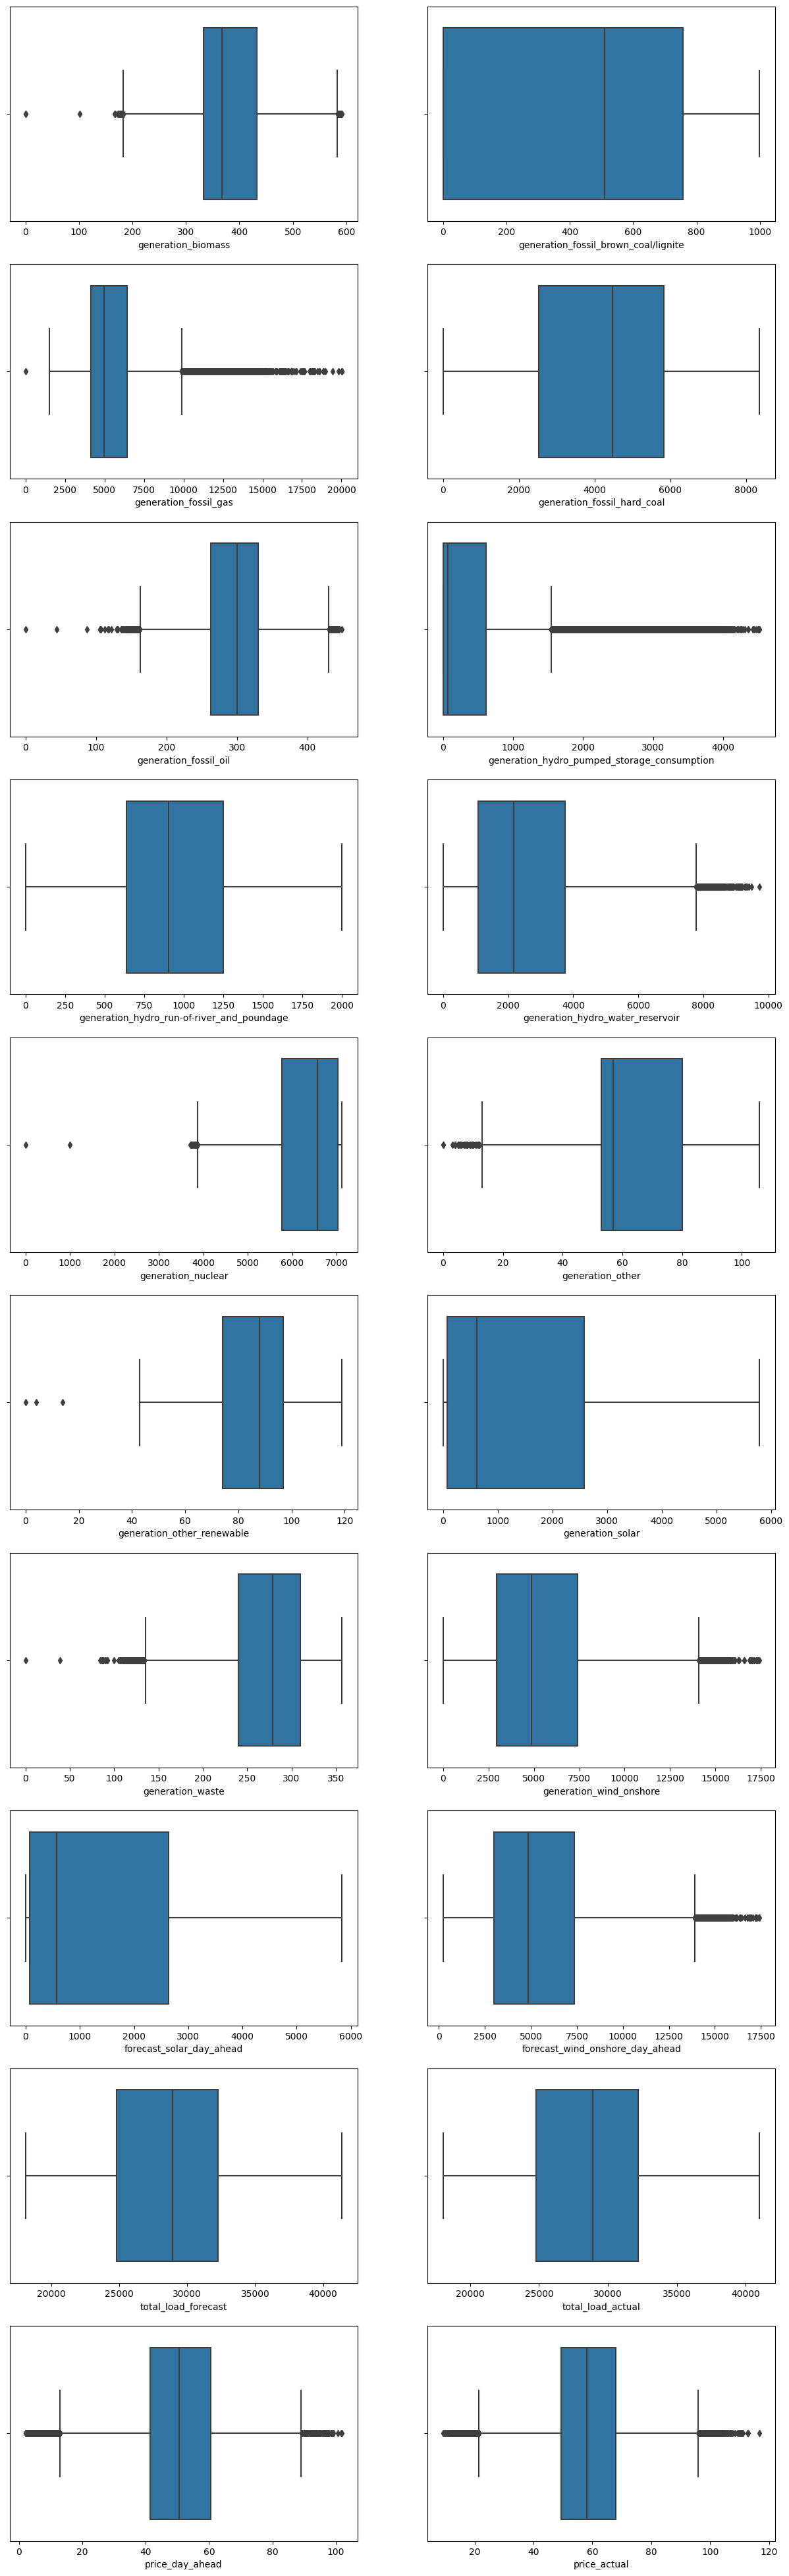

In [61]:
#boxplot to see the outliers 

plt.figure(figsize=(15,50))
columns = df.columns
for col in range(0,20):
    ax = plt.subplot(10,2,col+1)
    sns.boxplot(df[columns[col]], ax=ax)
    plt.xlabel(columns[col])


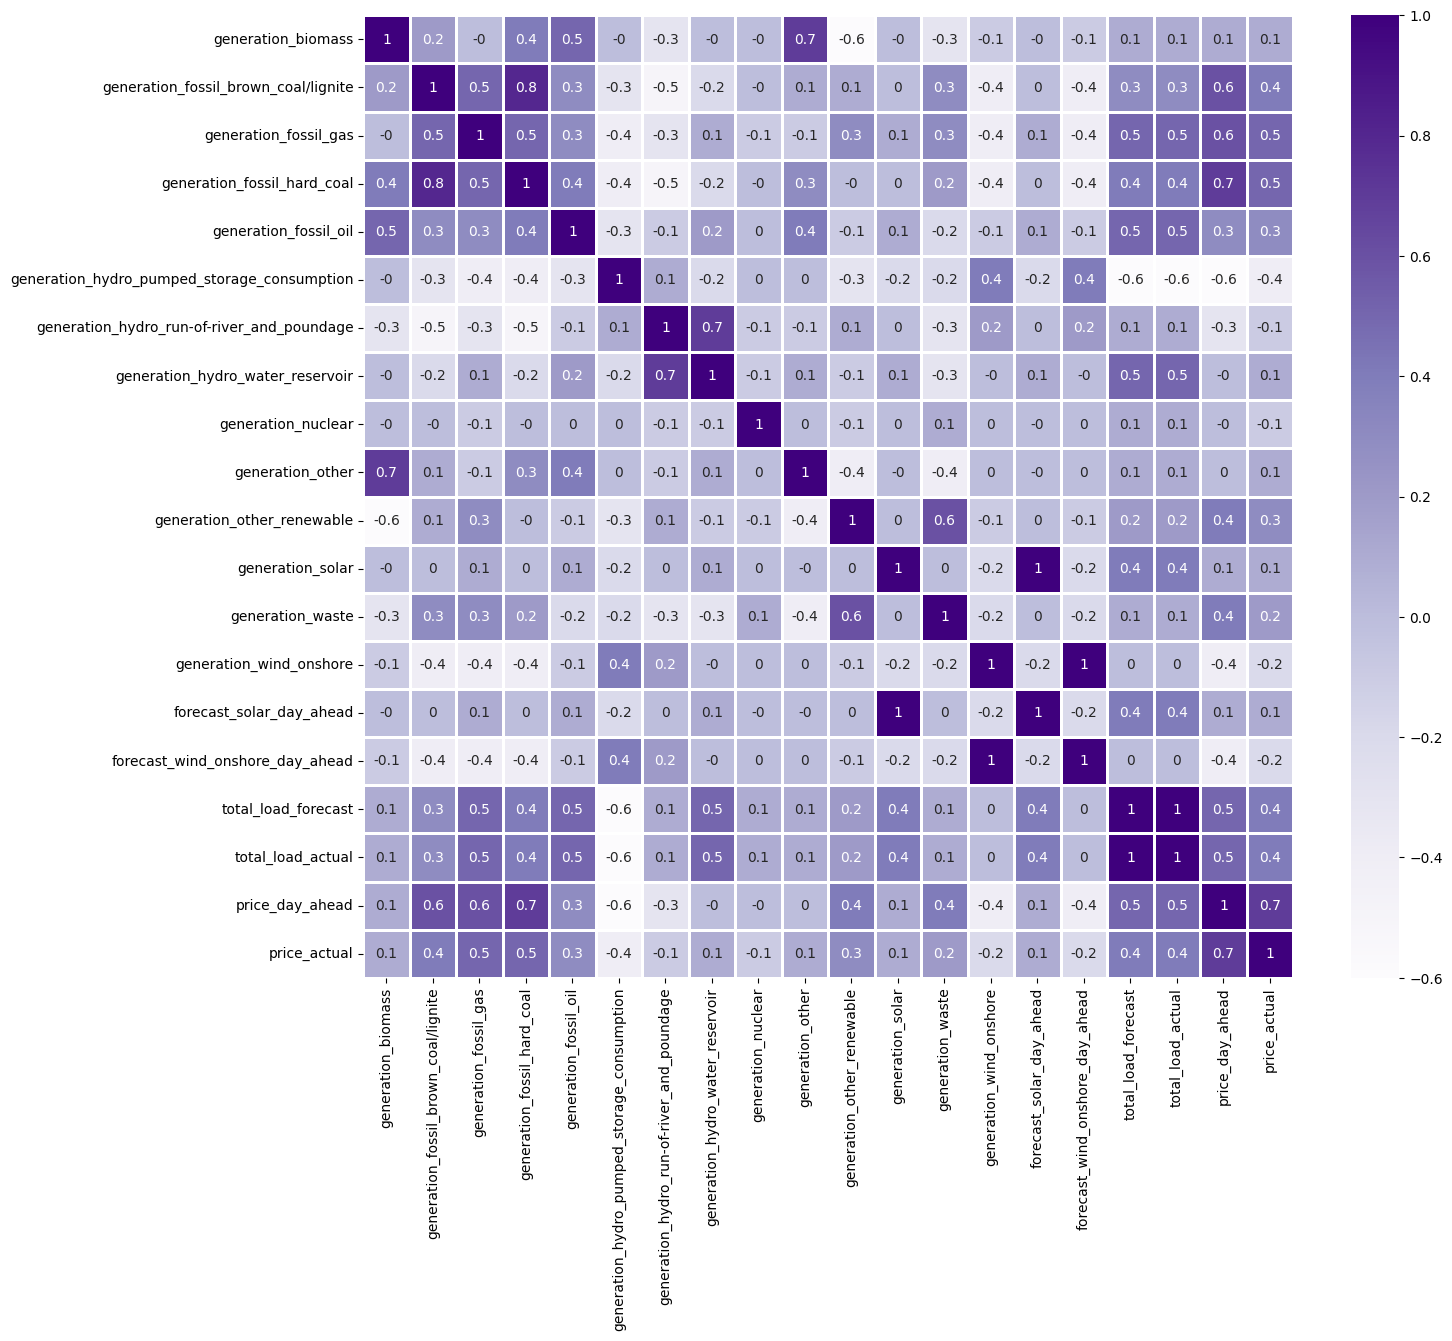

In [13]:
# Set Figure Size
plt.figure(figsize=(15,12.5))

# .corr heatmap of df to visualize correlation & show plot
sns.heatmap(round(df.corr(),1),annot=True,cmap='Purples',linewidth=0.9)
plt.show();

In [14]:
# Sort index
df = df.sort_index()

# Set conditional satements for filtering times of month to season value
condition_winter = (df.index.month>=1)&(df.index.month<=3)
condtion_spring = (df.index.month>=4)&(df.index.month<=6)
condition_summer = (df.index.month>=7)&(df.index.month<=9)
condition_automn = (df.index.month>=10)@(df.index.month<=12)

# Create column in dataframe that inputs the season based on the conditions created above
df['season'] = np.where(condition_winter,'winter',
                        np.where(condtion_spring,'spring',
                                 np.where(condition_summer,'summer',
                                          np.where(condition_automn,'autumn',np.nan))))

df

generation_biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation_fossil_oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                     

In [15]:
# Figure showing Price per total load
import plotly.express as px

fig = px.scatter(df,x='total_load_actual',
                 y='price_actual',
                 facet_col='season',
                 opacity=0.1,
                 title='Price Per MW Hour Compaired To Total Energy Genereated Per Season',)
                 #animation_frame=df.index.year)

# Figure customizations
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='darkslateblue')),
                  selector=dict(mode='markers'))

In [16]:
data_weather = import_clean_weather_data()
data_weather.head()

Importing weather_features data from /home/rahmah/code/marvinliebisch/forecasting-electricity-prices/raw_data/weather_features.csv...


city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+00:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0           0         800        clear   
2015-01-01 00:00:00+00:00      0.0           0         800        clear   
2015-01-01 01:00:00+00:00      0.0           0         800        clear   
2015-01-01 02:00:00+00:00      0.0           0         800        clear   
2015-01-01 03:00:00+00:00      0.0           0         800        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n

In [17]:
data_weather.groupby(['weather_id', 'weather_main', 'weather_icon']).count()

city_name  temp  temp_min  temp_max  \
weather_id weather_main weather_icon                                        
200        thunderstorm 11d                  52    52        52        52   
                        11n                  40    40        40        40   
201        thunderstorm 11d                  76    76        76        76   
                        11n                  51    51        51        51   
202        thunderstorm 11d                  18    18        18        18   
...                                         ...   ...       ...       ...   
803        clouds       04d                8212  8212      8212      8212   
                        04n                7037  7037      7037      7037   
804        clouds       04                  270   270       270       270   
                        04d                 925   925       925       925   
                        04n                1366  1366      1366      1366   

                                      pressure  humidity  wind_speed  \
weather_id weather_main weather_icon                                   
200        thunderstorm 11d                 52        52          52   
                        11n                 40        40          40   
201        thunderstorm 11d                 76        76          76   
                        11n                 51        51          51   
202        thunderstorm 11d                 18        18          18   
...                                        ...       ...         ...   
803        clouds       04d               8212      8212        8212   
                        04n               7037      7037        7037   
804        clouds       04                 270       270         270   
                        04d                925       925         925   
                        04n               1366      1366        1366   

                                      wind_deg  rain_1h  rain_3h  snow_3h  \
weather_id weather_main weather_icon                                        
200        thunderstorm 11d                 52       52       52       52   
                        11n                 40       40       40       40   
201        thunderstorm 11d                 76       76       76       76   
                        11n                 51       51       51       51   
202        thunderstorm 11d                 18       18       18       18   
...                                        ...      ...      ...      ...   
803        clouds       04d               8212     8212     8212     8212   
                        04n               7037     7037     7037     7037   
804        clouds       04                 270      270      270      270   
                        04d                925      925      925      925   
                        04n               1366     1366     1366     1366   

                                      clouds_all  weather_description  
weather_id weather_main weather_icon                                   
200        thunderstorm 11d                   52                   52  
                        11n                   40                   40  
201        thunderstorm 11d                   76                   76  
                        11n                   51                   51  
202        thunderstorm 11d                   18                   18  
...                                          ...                  ...  
803        clouds       04d                 8212                 8212  
                        04n                 7037                 7037  
804        clouds       04                   270                  270  
                        04d                  925                  925  
                        04n                 1366                 1366  

[84 rows x 13 columns]

In [18]:
data_weather.dtypes

city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [19]:
len(data_weather.dtypes)

16

In [20]:
data_weather.head()

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+00:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0           0         800        clear   
2015-01-01 00:00:00+00:00      0.0           0         800        clear   
2015-01-01 01:00:00+00:00      0.0           0         800        clear   
2015-01-01 02:00:00+00:00      0.0           0         800        clear   
2015-01-01 03:00:00+00:00      0.0           0         800        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n

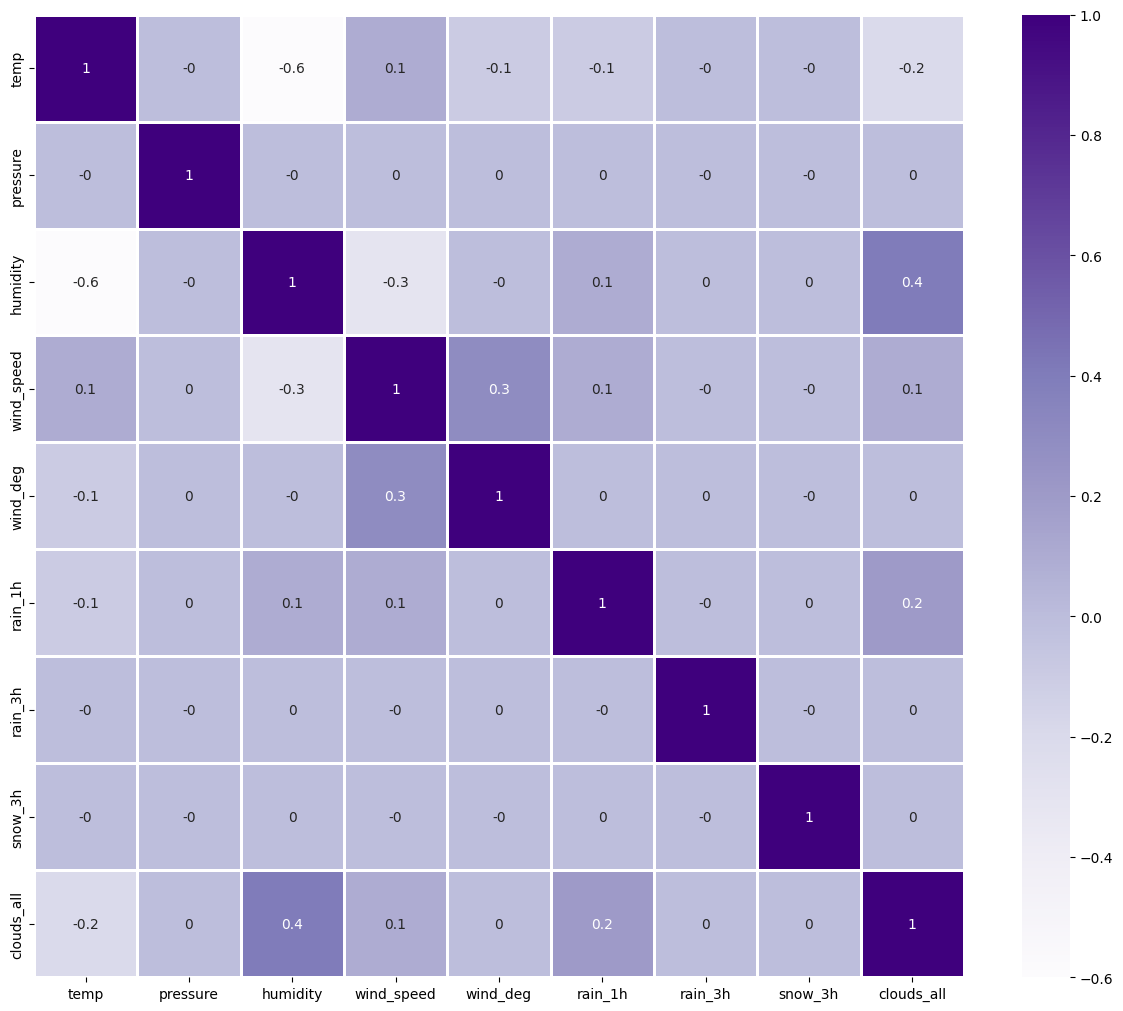

In [21]:
# Set Figure Size
plt.figure(figsize=(15,12.5))

# .corr heatmap of cleaned weather to visualize correlation & show plot
sns.heatmap(round(data_weather.drop(columns=['city_name','temp_min','temp_max','weather_id','weather_main','weather_description','weather_icon']).corr(),1),annot=True,cmap='Purples',linewidth=0.9)
plt.show();

In [34]:
# histogram to see normal distribution of weather data features 

# plt.figure(figsize=(15,7))
# columns = cleaned_weather.columns
# sns.histplot(cleaned_weather['temp_max'], kde=True)
# # for col in range(0,16):
#     ax = plt.subplot(10,2,col+1)
#     sns.histplot(cleaned_weather[columns[col]], kde=True, ax=ax)
#     plt.xlabel(columns[col])
#     plt.ylabel('count')

In [ ]:
# histogram to see normal distribution of weather data features 

# plt.figure(figsize=(15,7))
# columns = cleaned_weather.columns
# sns.histplot(cleaned_weather['temp_max'], kde=True)

In [22]:
merged_df = import_merged_data()
merged_df.head()

Importing energy_dataset data from /home/rahmah/code/marvinliebisch/forecasting-electricity-prices/raw_data/energy_dataset.csv...
Importing weather_features data from /home/rahmah/code/marvinliebisch/forecasting-electricity-prices/raw_data/weather_features.csv...


generation_biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation_fossil_oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation_hydro_run-of-river_and_poundage  \
time                                                                    
2014-12-31 23:00:00+00:00                                      1051.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 01:00:00+00:00                                       973.0   
2015-01-01 02:00:00+00:00                                       949.0   
2015-01-01 03:00:00+00:00                                       953.0   

                           generation_hydro_water_reservoir  \
time                                                          
2014-12-31 23:00:00+00:00                            1899.0   
2015-01-01 00:00:00+00:00                            1658.0   
2015-01-01 01:00:00+00:00                            1371.0   
2015-01-01 02:00:00+00:00                             779.0   
2015-01-01 03:00:00+00:00                             720.0   

                           generation_nuclear  generation_other  ...  \
time                                                             ...   
2014-12-31 23:00:00+00:00              7096.0              43.0  ...   
2015-01-01 00:00:00+00:00              7096.0              43.0  ...   
2015-01-01 01:00:00+00:00              7099.0              43.0  ...   
2015-01-01 02:00:00+00:00              7098.0              43.0  ...   
2015-01-01 03:00:00+00:00              7097.0              43.0  ...   

                           seville_humidity  seville_wind_speed  \
time                                                              
2014-12-31 23:00:00+00:00                75                   1   
2015-01-01 00:00:00+00:00                75                   1   
2015-01-01 01:00:00+00:00         

In [23]:
merged_df.dtypes

generation_biomass                      float64
generation_fossil_brown_coal/lignite    float64
generation_fossil_gas                   float64
generation_fossil_hard_coal             float64
generation_fossil_oil                   float64
                                         ...   
seville_snow_3h                         float64
seville_clouds_all                        int64
seville_weather_id                        int64
seville_weather_main                     object
seville_weather_description              object
Length: 85, dtype: object

In [24]:
len(merged_df.dtypes)

85

In [25]:
merged_df.dtypes.value_counts()

float64    40
int64      34
object     11
dtype: int64

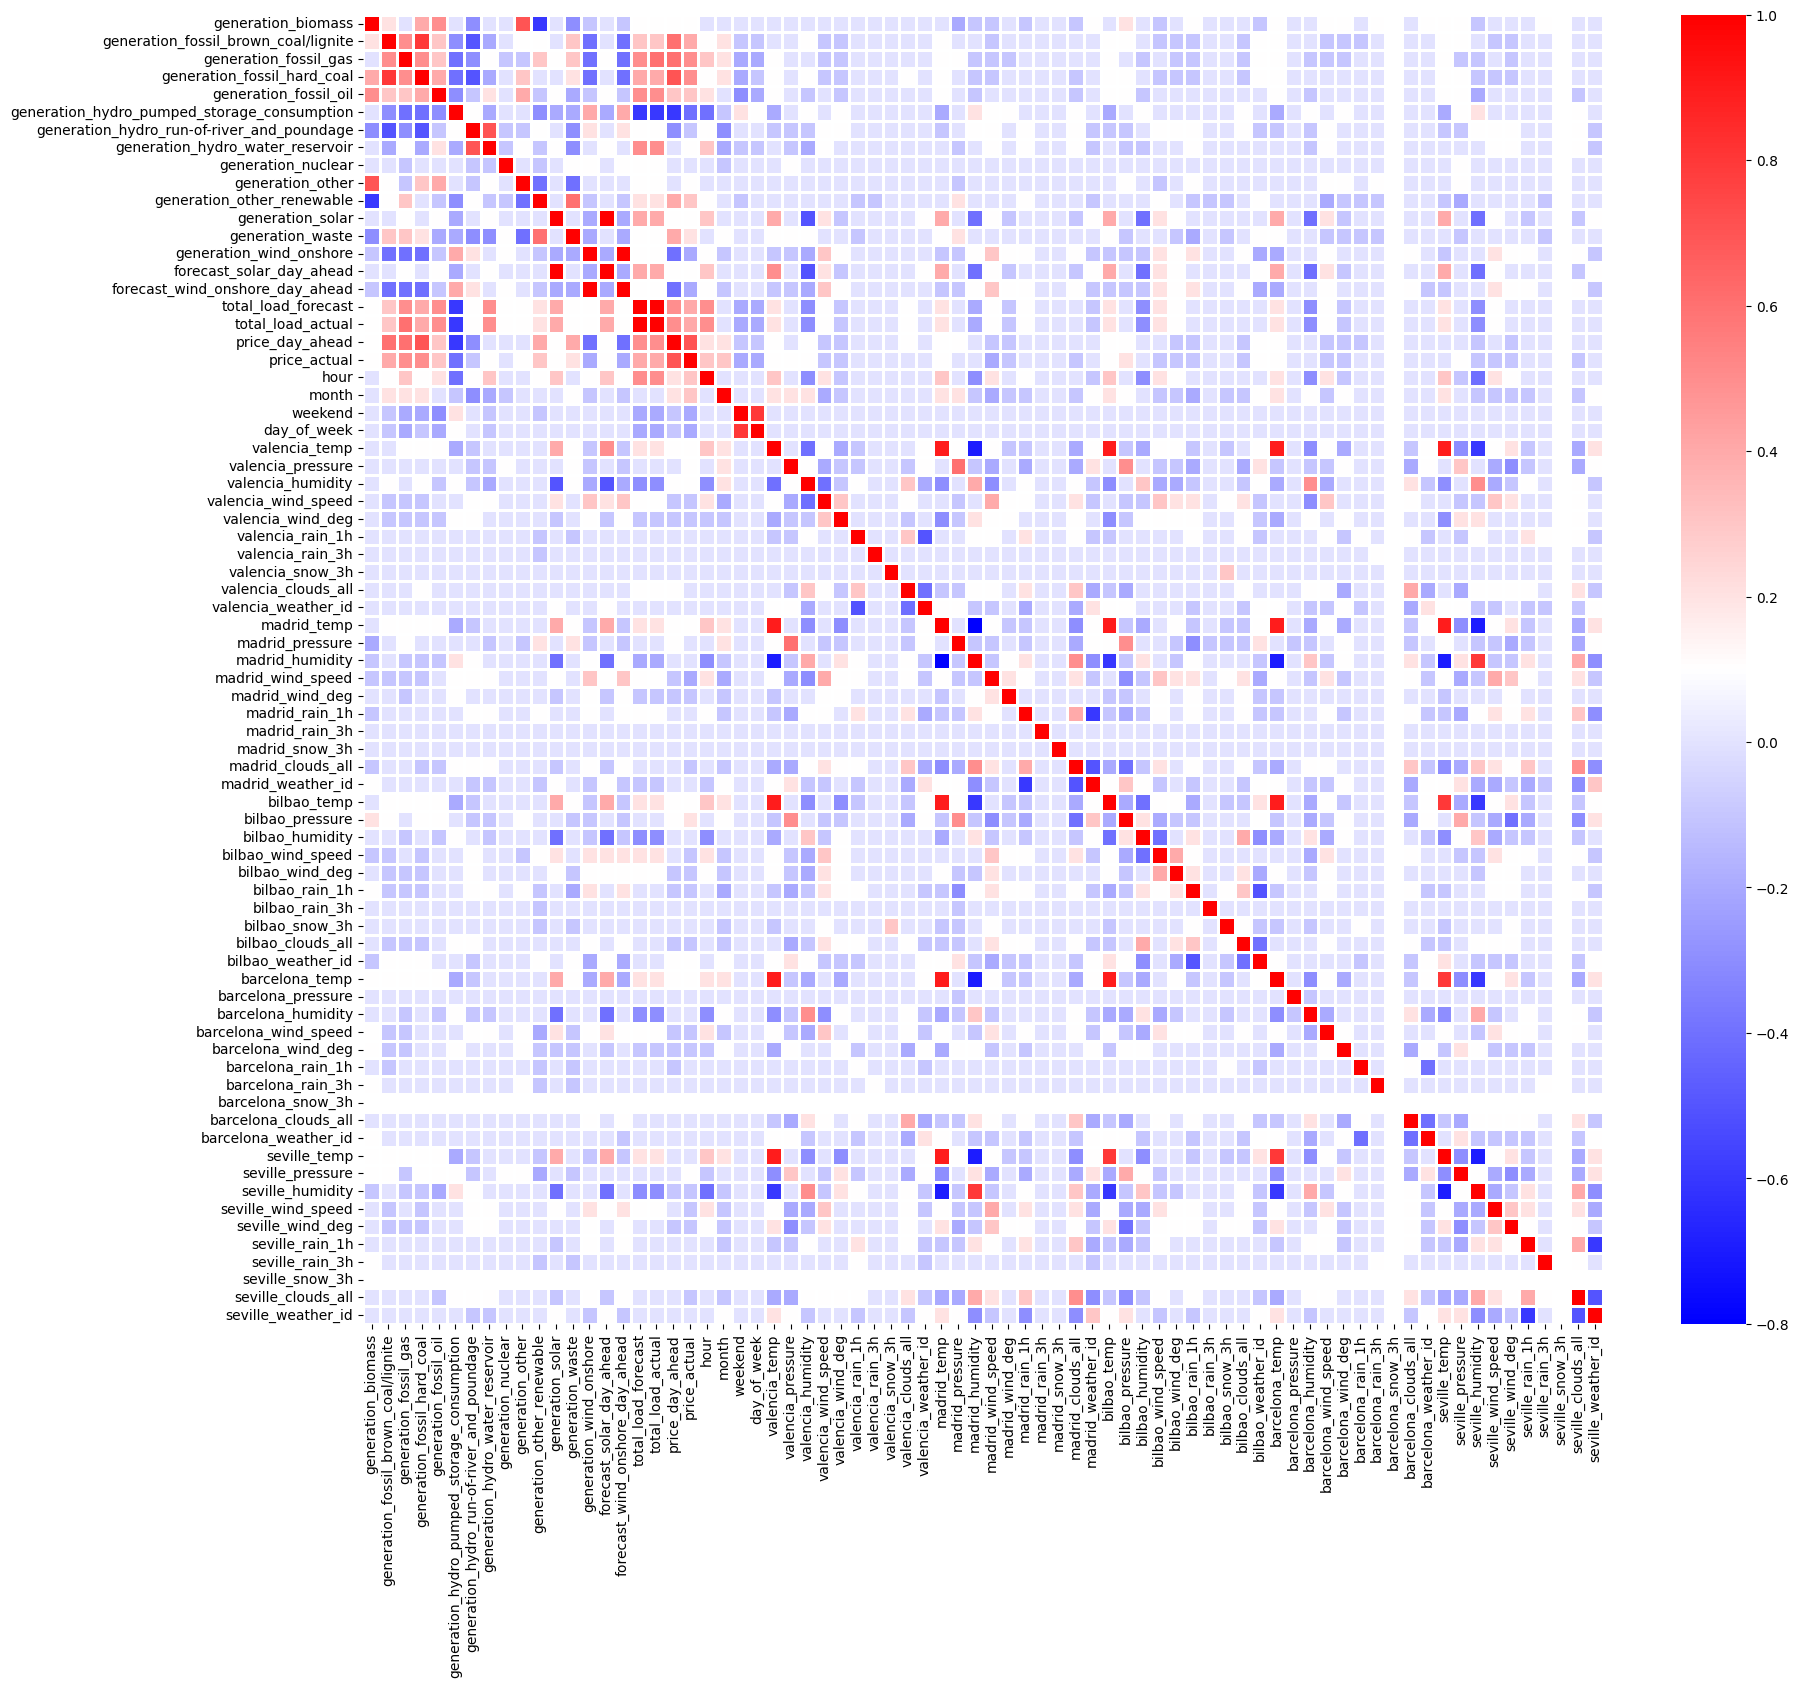

In [26]:
plt.figure(figsize=(20,17))

# .corr heatmap of cleaned weather to visualize correlation & show plot
sns.heatmap(round(merged_df.select_dtypes(include=['float64','int64']).corr(),1),cmap='bwr',linewidth=0.9)
plt.show();

<AxesSubplot:xlabel='seville_weather_main', ylabel='count'>

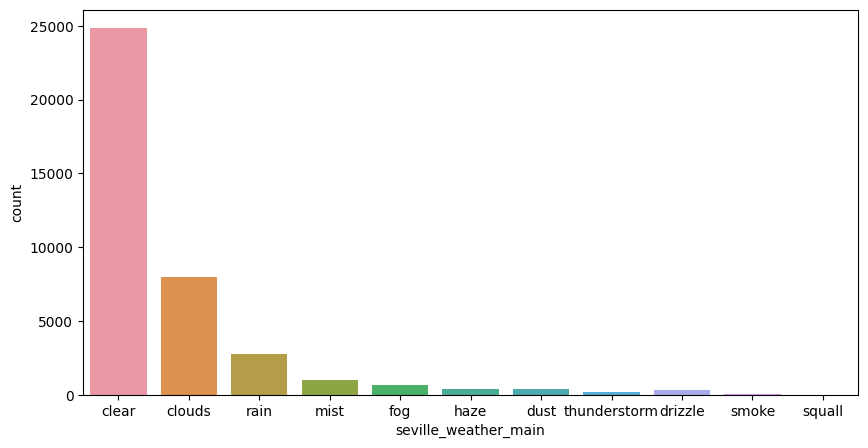

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.countplot(data=merged_df, x='seville_weather_main', ax=ax)

In [28]:
correlations = merged_df.corr(method='pearson')
features_price_day_ahead = np.abs(correlations['price_day_ahead']).drop(['price_actual'])
features_price_day_ahead_selected = features_price_day_ahead[features_price_day_ahead > 0.2]
features_price_day_ahead_selected

generation_fossil_brown_coal/lignite           0.564274
generation_fossil_gas                          0.640904
generation_fossil_hard_coal                    0.669100
generation_fossil_oil                          0.284943
generation_hydro_pumped_storage_consumption    0.599573
generation_hydro_run-of-river_and_poundage     0.294294
generation_other_renewable                     0.434742
generation_waste                               0.370586
generation_wind_onshore                        0.410209
forecast_wind_onshore_day_ahead                0.414382
total_load_forecast                            0.477127
total_load_actual                              0.476682
price_day_ahead                                1.000000
hour                                           0.239557
Name: price_day_ahead, dtype: float64

In [29]:
selected_features = list(features_price_day_ahead_selected.index)
selected_features

['generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_other_renewable',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'total_load_actual',
 'price_day_ahead',
 'hour']

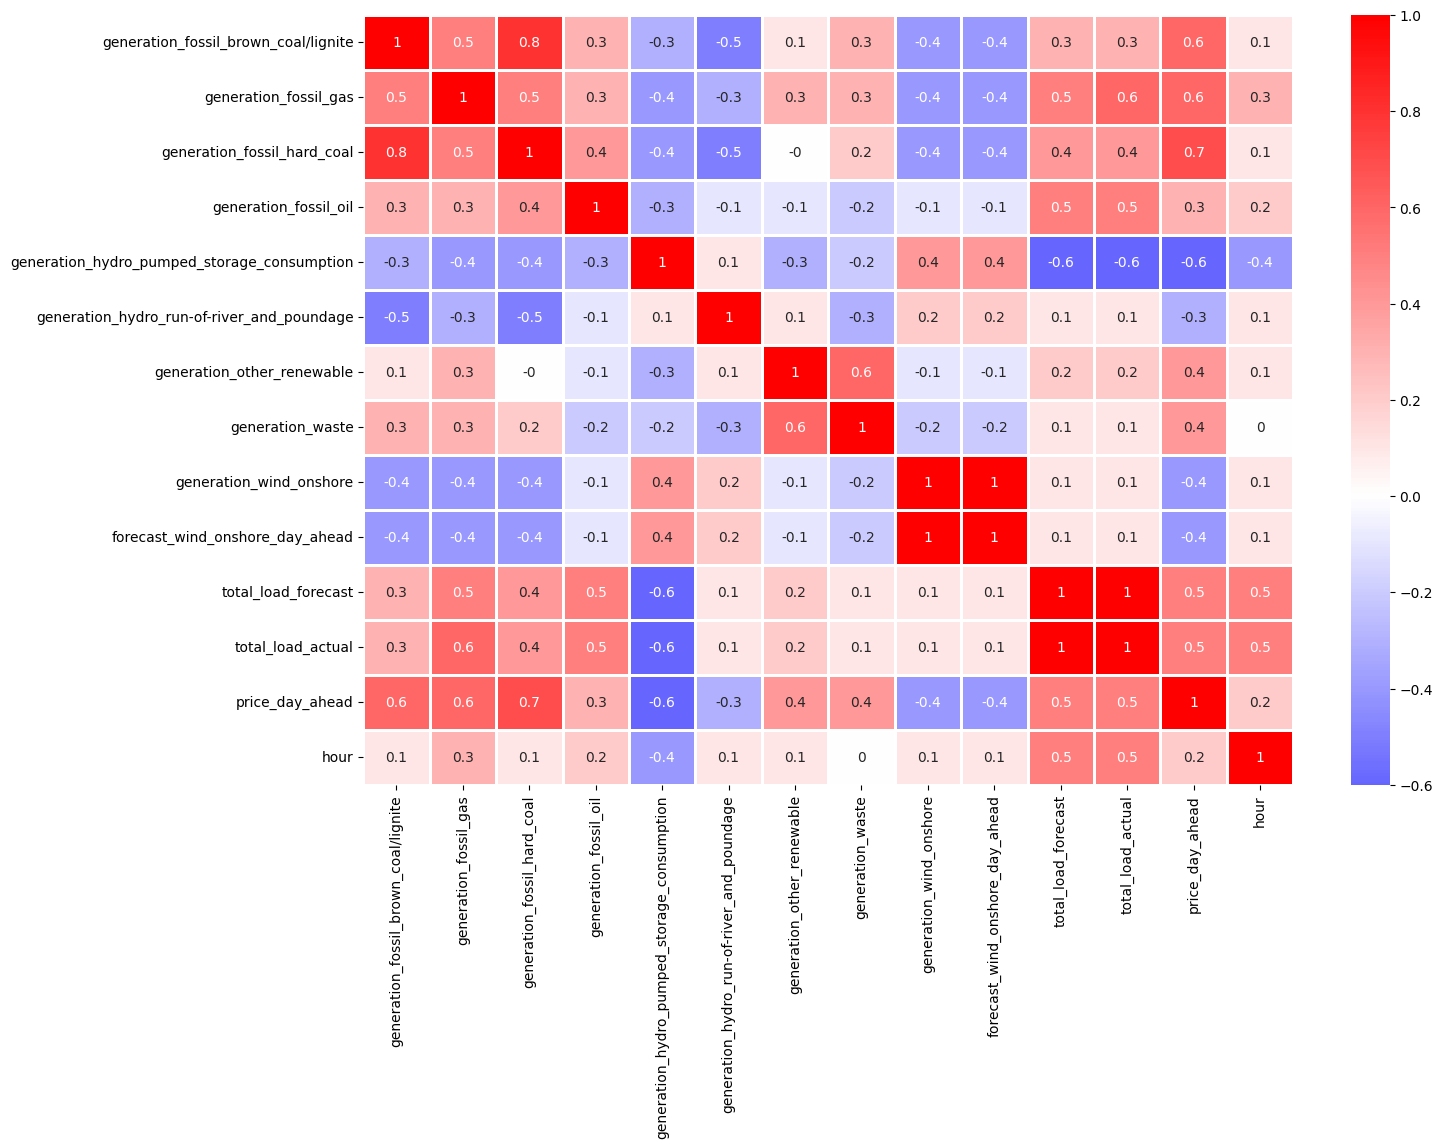

In [30]:
plt.figure(figsize=(15,10))

# .corr heatmap of selected features to visualize correlation & show plot
sns.heatmap(round(merged_df[selected_features].corr(),1),cmap='bwr',linewidth=0.9, center=0, annot=True)
plt.show();

In [196]:
#merged_df.columns

In [31]:
merged_df

generation_biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation_fossil_oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   
...                                          ...   
2018-12-31 18:00:00+00:00                  178.0   
2018-12-31 19:00:00+00:00                  174.0   
2018-12-31 20:00:00+00:00                  168.0   
2018-12-31 21:00:00+00:00                  163.0   
2018-12-31 22:00:00+00:00                  163.0   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   
...                                                                ...   
2018-12-31 18:00:00+00:00                                          1.0   
2018-12-31 19:00:00+00:00                                          1.0   
2018-12-31 20:00:00+00:00                     

In [32]:
generation_features = [col for col in merged_df.columns if 'generation' in col]
generation_features

['generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore']

In [33]:
fossil_sources = ['generation_fossil_brown_coal/lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil']
nonfossil_sources = [col for col in merged_df.columns if 'generation' in col and col not in fossil_sources]

In [34]:
energy_df = merged_df.reset_index().melt(id_vars=['time'], value_vars=generation_features)
energy_df

time                 variable   value
0      2014-12-31 23:00:00+00:00       generation_biomass   447.0
1      2015-01-01 00:00:00+00:00       generation_biomass   449.0
2      2015-01-01 01:00:00+00:00       generation_biomass   448.0
3      2015-01-01 02:00:00+00:00       generation_biomass   438.0
4      2015-01-01 03:00:00+00:00       generation_biomass   428.0
...                          ...                      ...     ...
539303 2018-12-31 18:00:00+00:00  generation_wind_onshore  3113.0
539304 2018-12-31 19:00:00+00:00  generation_wind_onshore  3288.0
539305 2018-12-31 20:00:00+00:00  generation_wind_onshore  3503.0
539306 2018-12-31 21:00:00+00:00  generation_wind_onshore  3586.0
539307 2018-12-31 22:00:00+00:00  generation_wind_onshore  3651.0

[539308 rows x 3 columns]

In [35]:
#energy_df['generation_fossil'] = 
energy_df['is_fossil'] = energy_df['variable'].isin(fossil_sources)
energy_df

time                 variable   value  is_fossil
0      2014-12-31 23:00:00+00:00       generation_biomass   447.0      False
1      2015-01-01 00:00:00+00:00       generation_biomass   449.0      False
2      2015-01-01 01:00:00+00:00       generation_biomass   448.0      False
3      2015-01-01 02:00:00+00:00       generation_biomass   438.0      False
4      2015-01-01 03:00:00+00:00       generation_biomass   428.0      False
...                          ...                      ...     ...        ...
539303 2018-12-31 18:00:00+00:00  generation_wind_onshore  3113.0      False
539304 2018-12-31 19:00:00+00:00  generation_wind_onshore  3288.0      False
539305 2018-12-31 20:00:00+00:00  generation_wind_onshore  3503.0      False
539306 2018-12-31 21:00:00+00:00  generation_wind_onshore  3586.0      False
539307 2018-12-31 22:00:00+00:00  generation_wind_onshore  3651.0      False

[539308 rows x 4 columns]

In [36]:
energy_agg_df = energy_df.groupby(['time', 'is_fossil']).sum('value').reset_index()
energy_agg_df

time  is_fossil    value
0     2014-12-31 23:00:00+00:00      False  18095.0
1     2014-12-31 23:00:00+00:00       True  10156.0
2     2015-01-01 00:00:00+00:00      False  17381.0
3     2015-01-01 00:00:00+00:00       True  10437.0
4     2015-01-01 01:00:00+00:00      False  16878.0
...                         ...        ...      ...
70031 2018-12-31 20:00:00+00:00       True   9615.0
70032 2018-12-31 21:00:00+00:00      False  13730.0
70033 2018-12-31 21:00:00+00:00       True   9018.0
70034 2018-12-31 22:00:00+00:00      False  13350.0
70035 2018-12-31 22:00:00+00:00       True   9255.0

[70036 rows x 3 columns]

<AxesSubplot:xlabel='time', ylabel='value'>

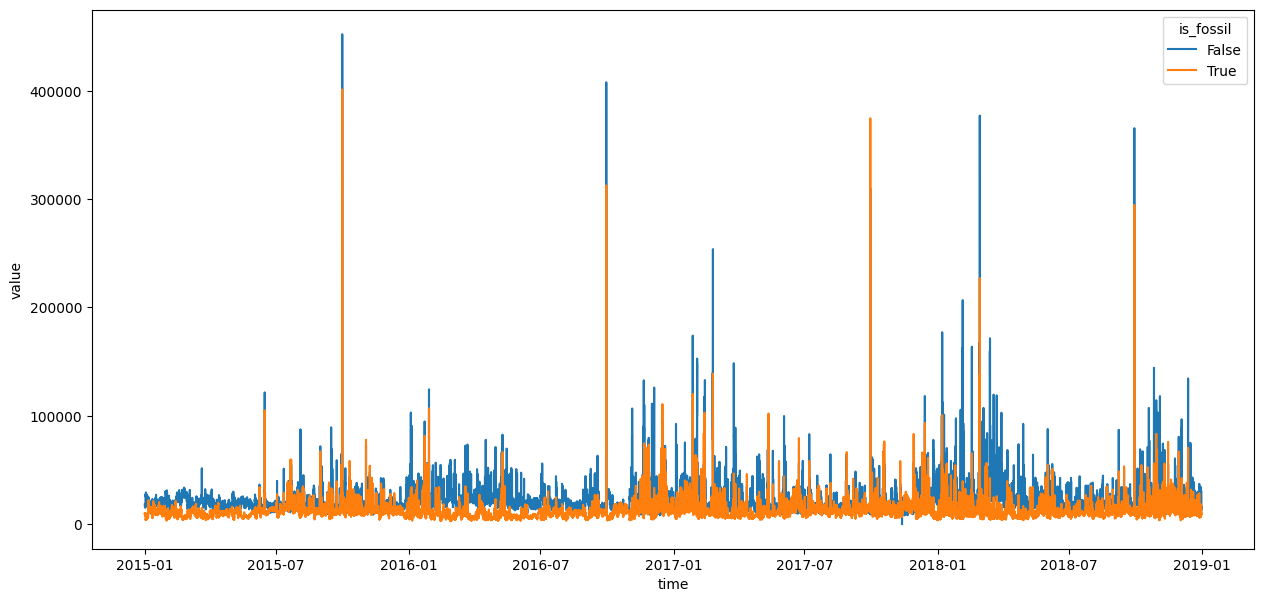

In [37]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=energy_agg_df, x='time', y='value', hue='is_fossil', ax=ax)

<AxesSubplot:xlabel='time', ylabel='value'>

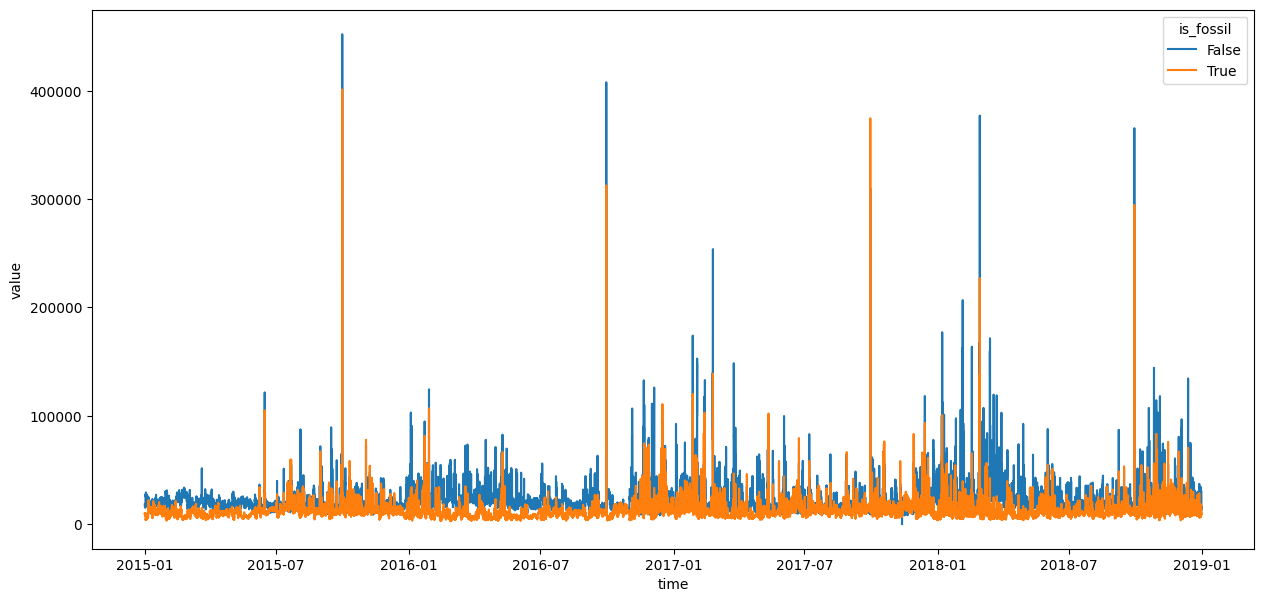

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=energy_agg_df, x='time', y='value', hue='is_fossil', ax=ax)

In [39]:
energy_agg_df['date'] = energy_agg_df['time'].apply(lambda x: x.date())

In [40]:
energy_agg_date_df = energy_agg_df.groupby(['date', 'is_fossil']).sum().reset_index()

<AxesSubplot:xlabel='date', ylabel='value'>

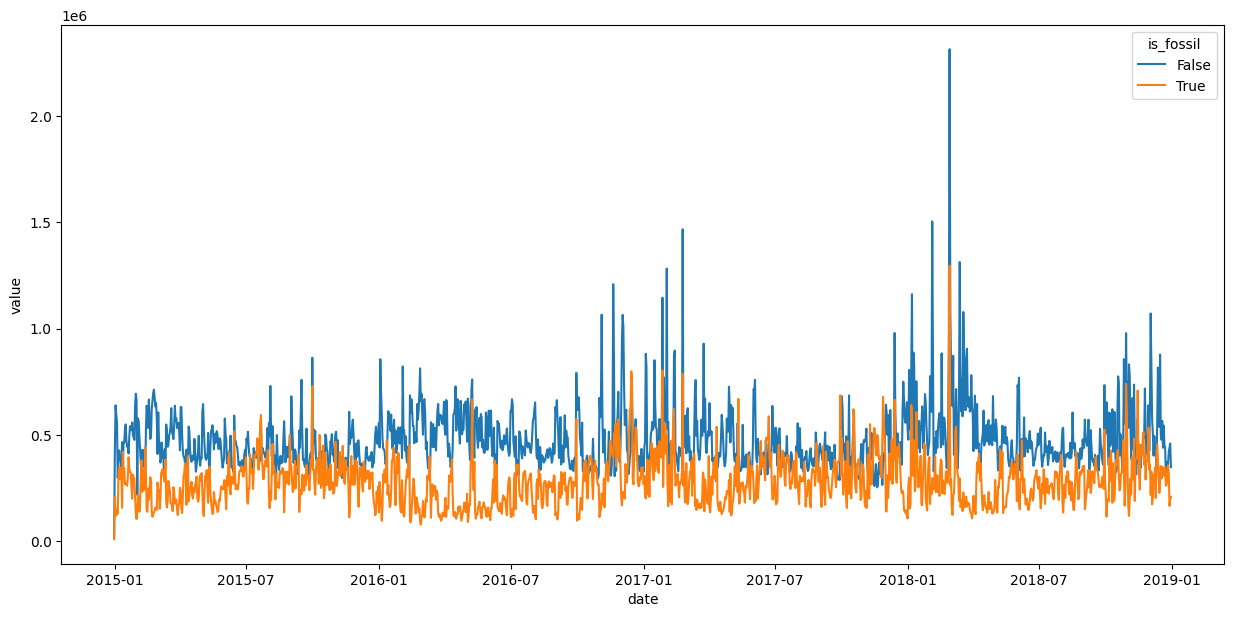

In [41]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=energy_agg_date_df, x='date', y='value', hue='is_fossil', ax=ax)

In [42]:
energy_agg_df['year_month'] = energy_agg_df['date'].astype('string').apply(lambda x: x[:7])

In [43]:
energy_agg_ymonth_df = energy_agg_df.groupby(['year_month', 'is_fossil']).sum().reset_index()

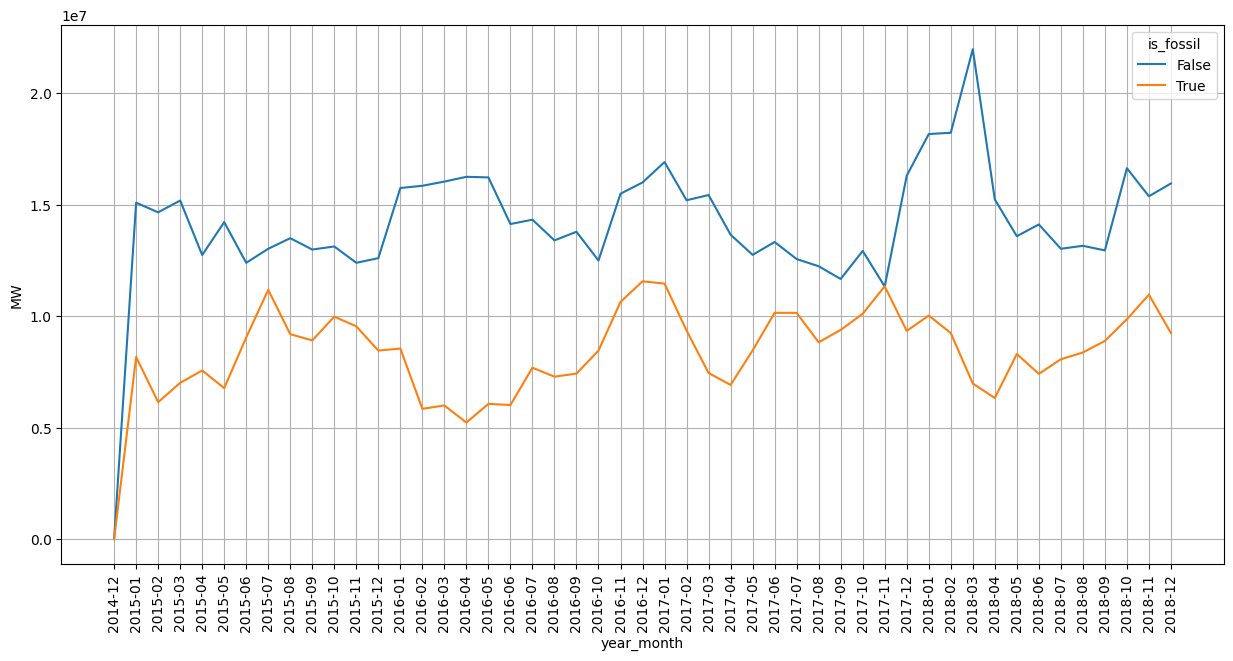

In [44]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=energy_agg_ymonth_df, x='year_month', y='value', hue='is_fossil', ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('MW')
ax.grid(True)